# ***MAKEMORE: BACKPROP STEP BY STEP***

### Importing Libs

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

### Reading list of names (all lowered already)

In [3]:
words = open("names.txt", "r").read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

### Building vocab of chars and mapping into integers

In [23]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


### Build dataset

In [24]:
block_size = 3
X, Y = [], []
for w in words:
    
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context.copy())
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

### Train Test Validation splits

In [25]:
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    return torch.tensor(X), torch.tensor(Y)

import random
random.seed(42)
random.shuffle(words)

# 80% train, 10% validation, 10% test
train = words[:int(.8 * len(words))]
valid = words[int(.8 * len(words)):int(.9 * len(words))]
test = words[int(.9 * len(words)):]

X_train, Y_train = build_dataset(train)
X_valid, Y_valid = build_dataset(valid)
X_test, Y_test = build_dataset(test)

In [26]:
X_train.shape, X_valid.shape, X_test.shape

(torch.Size([182580, 3]), torch.Size([22767, 3]), torch.Size([22799, 3]))

###  Compare grads function
Check if our gradients calculation is similar to pytorch

In [27]:
def compare(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} exact: {ex} approx: {app} maxdiff: {maxdiff:.1e}')

### MLP
Adjusting the intialization weights so that the gaussians keep std =~ 1. More details on <a href="https://pytorch.org/docs/stable/nn.init.html"> this link </a>



In [28]:
# Embedding matrix
n_emb = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, n_emb), generator=g)
# MLP weights and biases
# Layer 1
W1 = torch.randn((n_emb*block_size, n_hidden), generator=g) * (5/3)/((n_emb*block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01 #OBS: B1 is useless
# Layer 2
W2 = torch.randn((n_hidden, 27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0.0
# Batchnorm parameters
bn_gain = torch.ones((1, n_hidden))
bn_bias = torch.zeros((1, n_hidden))
# OBS: Running mean and std are not parameters, they are just tensors
# that are updated during training
bn_mean_running = torch.zeros((1, n_hidden))
bn_std_running = torch.ones((1, n_hidden))

params = [C, W1, b1, W2, b2, bn_gain, bn_bias]

for p in params:
    p.requires_grad = True
print(sum(p.nelement() for p in params), "parameters")

12297 parameters


### Forward once

In [29]:
batch_size = 32
n = batch_size # a shorter variable 
# construct a minibatch
ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
Xb, Yb = X_train[ix], Y_train[ix] # batch X,Y

In [30]:
emb = C[Xb]
embcat = emb.view(emb.shape[0], -1)
# Lin Layer 1
h_pre_bn = (embcat @ W1) + b1
# Batchnorm
bn_mean_i = (1/batch_size)*h_pre_bn.sum(0, keepdim=True)
bn_diff = h_pre_bn - bn_mean_i
bn_diff_2 = bn_diff**2
bn_var = (1/(n-1))*bn_diff_2.sum(0, keepdim=True)
bn_var_inv = (bn_var + 1e-5)**-0.5
bn_raw = bn_diff * bn_var_inv
h_preact = (bn_gain * bn_raw) + bn_bias
# Tanh Activation
h = torch.tanh(h_preact)
# Lin Layer 2
logits = (h@W2) + b2 # output
# Loss (cross entropy)
logits_maxes = logits.max(axis=1, keepdim=True).values
norm_logits  = logits - logits_maxes
counts = norm_logits.exp()
counts_sum = counts.sum(axis=1, keepdim=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# Backward pass with PyTorch
for p in params:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logits_maxes, logits, h, h_preact, bn_raw,
         bn_var_inv, bn_var, bn_diff_2, bn_diff, h_pre_bn, bn_mean_i,
         embcat, emb]:
    t.retain_grad()
loss.backward()
loss

tensor(3.3014, grad_fn=<NegBackward0>)

## **PART 1: Backprop through ALL tensors manually**

In [31]:
bn_diff.shape, bn_raw.shape, bn_var_inv.shape

(torch.Size([32, 200]), torch.Size([32, 200]), torch.Size([1, 200]))

In [32]:
bn_diff_2.shape

torch.Size([32, 200])

In [33]:
C.shape, emb.shape

(torch.Size([27, 10]), torch.Size([32, 3, 10]))

In [34]:
# LogProbs
d_log_probs = torch.zeros_like(logprobs)
d_log_probs[range(n), Yb] = -1/n # dL/d(logprobs)

# Probs
d_probs = (1.0/probs) * d_log_probs

d_counts_sum_inv = (d_probs * counts).sum(axis=1, keepdim=True)
d_counts = d_probs * counts_sum_inv
d_counts_sum = (-counts_sum**-2) * d_counts_sum_inv
d_counts += torch.ones(counts.shape) * d_counts_sum
d_norm_logits = d_counts*norm_logits.exp()
d_logits = d_norm_logits.clone()
d_logits_maxes = -d_logits.sum(axis=1, keepdim=True)
d_logits += d_logits_maxes * (logits == logits_maxes).float()
d_h = d_logits @ W2.T
d_W2 = h.T @ d_logits
d_b2 = d_logits.sum(0)
d_h_preact = (1.0 - h**2) * d_h
# use exact grad here
#'cause there's a slight difference between the two methods
d_bn_gain = (bn_raw * h_preact.grad).sum(0, keepdim=True)
d_bn_raw = (bn_gain * h_preact.grad)
d_bn_bias = h_preact.grad.sum(0, keepdim=True)
d_bn_diff = bn_var_inv * d_bn_raw
d_bn_var_inv = (bn_diff * d_bn_raw).sum(0, keepdim=True)
d_bn_var = (-0.5 * ((bn_var + 1e-5)**-1.5) * d_bn_var_inv)
d_bn_diff_2 = (1.0/(n-1)) * d_bn_var
d_bn_diff += (2 * bn_diff) * d_bn_diff_2
d_h_pre_bn = d_bn_diff
d_bn_mean_i = -d_bn_diff.sum(0, keepdim=True)
d_h_pre_bn += d_bn_mean_i*(1/batch_size)*torch.ones_like(h_pre_bn)
d_embcat = d_h_pre_bn @ W1.T
d_W1 = embcat.T @ d_h_pre_bn
d_b1 = d_h_pre_bn.sum(0)
d_emb = d_embcat.view(emb.shape)
d_C = torch.zeros_like(C)
for i in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    idx = Xb[i,j]
    d_C[idx] += d_emb[i,j]


# Compare gradients
compare("logprobs", d_log_probs, logprobs)
compare("probs", d_probs, probs)
compare("counts_sum_inv", d_counts_sum_inv, counts_sum_inv)
compare("counts_sum", d_counts_sum, counts_sum)
compare("counts", d_counts, counts)
compare("norm_logits", d_norm_logits, norm_logits)
compare("logits", d_logits, logits)
compare("logits_maxes", d_logits_maxes, logits_maxes)
compare("h", d_h, h)
compare("W2", d_W2, W2)
compare("b2", d_b2, b2)
compare("h_preact", d_h_preact, h_preact)
compare("bn_gain", d_bn_gain, bn_gain)
compare("bn_raw", d_bn_raw, bn_raw)
compare("bn_bias", d_bn_bias, bn_bias)
compare("bn_diff", d_bn_diff, bn_diff)
compare("bn_var_inv", d_bn_var_inv, bn_var_inv)
compare("bn_var", d_bn_var, bn_var)
compare("bn_diff_2", d_bn_diff_2, bn_diff_2)
compare("h_pre_bn", d_h_pre_bn, h_pre_bn)
compare("bn_mean_i", d_bn_mean_i, bn_mean_i)
compare("embcat", d_embcat, embcat)
compare("W1", d_W1, W1)
compare("b1", d_b1, b1)
compare("emb", d_emb, emb)
compare("C", d_C, C)

logprobs        exact: True approx: True maxdiff: 0.0e+00
probs           exact: True approx: True maxdiff: 0.0e+00
counts_sum_inv  exact: True approx: True maxdiff: 0.0e+00
counts_sum      exact: True approx: True maxdiff: 0.0e+00
counts          exact: True approx: True maxdiff: 0.0e+00
norm_logits     exact: True approx: True maxdiff: 0.0e+00
logits          exact: True approx: True maxdiff: 0.0e+00
logits_maxes    exact: True approx: True maxdiff: 0.0e+00
h               exact: True approx: True maxdiff: 0.0e+00
W2              exact: True approx: True maxdiff: 0.0e+00
b2              exact: True approx: True maxdiff: 0.0e+00
h_preact        exact: False approx: True maxdiff: 5.8e-11
bn_gain         exact: True approx: True maxdiff: 0.0e+00
bn_raw          exact: True approx: True maxdiff: 0.0e+00
bn_bias         exact: True approx: True maxdiff: 0.0e+00
bn_diff         exact: False approx: False maxdiff: 1.4e-04
bn_var_inv      exact: True approx: True maxdiff: 0.0e+00
bn_var     

## **Exercise 2: backprop through cross_entropy but all in one go**

In [35]:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.301448106765747 diff: -2.384185791015625e-07


In [36]:
d_logits = F.softmax(logits, 1)
d_logits[range(n), Yb] -= 1
d_logits /= n

compare("logits", d_logits, logits)

logits          exact: False approx: True maxdiff: 6.9e-09


In [37]:
d_logits[0] * n

tensor([ 0.0373,  0.0335,  0.0314,  0.0376,  0.0439, -0.9582,  0.0406,  0.0351,
         0.0386,  0.0335,  0.0340,  0.0332,  0.0371,  0.0434,  0.0329,  0.0307,
         0.0416,  0.0359,  0.0348,  0.0422,  0.0403,  0.0307,  0.0467,  0.0447,
         0.0335,  0.0362,  0.0289], grad_fn=<MulBackward0>)

## **Exercise 3: backprop straightforward through batchnorm**

In [38]:
hpreact_fast = bn_gain * (h_pre_bn - h_pre_bn.mean(0, keepdim=True)) / torch.sqrt(h_pre_bn.var(0, keepdim=True, unbiased=True) + 1e-5) + bn_bias
print('max diff:', (hpreact_fast - h_preact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


## **Exercise 4: Manually optimize the NN without loss.backward()**

In [39]:
batch_size = 32
n = batch_size # a shorter variable 
n_steps = 100000
lossi = []
with torch.no_grad():
    for i in range(n_steps):
        # Sample the batch
        ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
        Xb, Yb = X_train[ix], Y_train[ix] # batch X,Y
        # take the embeddings
        emb = C[Xb]
        embcat = emb.view(emb.shape[0], -1)
        # Lin Layer 1
        h_pre_bn = (embcat @ W1) + b1
        # Batchnorm
        bn_mean = h_pre_bn.mean(0, keepdim=True)
        bn_var = h_pre_bn.var(0, keepdim=True, unbiased=True)
        bn_var_inv = (bn_var + 1e-5)**-0.5
        bn_raw = (h_pre_bn - bn_mean) * bn_var_inv
        h_preact = bn_gain * bn_raw + bn_bias
        # Tanh Activation
        h = torch.tanh(h_preact)
        # Lin Layer 2
        logits = (h@W2) + b2 # output
        # Loss (cross entropy)
        loss = F.cross_entropy(logits, Yb)

        # Backward pass
        for p in params:
            p.grad = None

        # Our own backprop
        d_logits = F.softmax(logits, 1)
        d_logits[range(n), Yb] -= 1
        d_logits /= n
        # Layer 2 backprop
        d_h = d_logits @ W2.T
        d_W2 = h.T @ d_logits
        d_b2 = d_logits.sum(0)
        # Tanh activation backprop
        d_h_preact = (1.0 - h**2) * d_h
        # Batch Normalization backprop
        d_bn_gain = (bn_raw * d_h_preact).sum(0, keepdim=True)
        d_bn_bias = d_h_preact.sum(0, keepdim=True)
        d_h_pre_bn = bn_gain*bn_var_inv/n * (n*d_h_preact - d_h_preact.sum(0) - n/(n-1)*bn_raw*(d_h_preact*bn_raw).sum(0))
        # Layer 1 backprop
        d_embcat = d_h_pre_bn @ W1.T
        d_W1 = embcat.T @ d_h_pre_bn
        d_b1 = d_h_pre_bn.sum(0)
        # Embedding backprop
        d_emb = d_embcat.view(emb.shape)
        d_C = torch.zeros_like(C)
        for k in range(Xb.shape[0]):
            for j in range(Xb.shape[1]):
                ix = Xb[k,j]
                d_C[ix] += d_emb[k,j]
        grads = [d_C, d_W1, d_b1, d_W2, d_b2, d_bn_gain, d_bn_bias]
        # End of backprop

        # Update the parameters
        lr = 0.1 if i < 100000 else 0.01 # Decay the learning rate
        for p, grad in zip(params, grads):
            p.data += -lr * grad

        # Follow the loss
        if i % 10000 == 0:
            print(f'{i:7d}/{n_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())

      0/ 100000: 3.3100
  10000/ 100000: 2.3046
  20000/ 100000: 2.1078
  30000/ 100000: 2.3260
  40000/ 100000: 2.5696
  50000/ 100000: 2.3081
  60000/ 100000: 2.2972
  70000/ 100000: 1.8720
  80000/ 100000: 2.1814
  90000/ 100000: 2.2426


### Check how gaussians behave through forward pass

tensor(0.0015) tensor(0.9988)
tensor(-0.0003) tensor(1.0039)


(array([1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        2.0000e+00, 5.0000e+00, 5.0000e+00, 4.0000e+00, 1.2000e+01,
        1.4000e+01, 1.5000e+01, 2.2000e+01, 2.6000e+01, 6.0000e+01,
        4.0000e+01, 6.3000e+01, 1.2300e+02, 1.1500e+02, 1.7700e+02,
        2.3100e+02, 2.7000e+02, 3.8100e+02, 5.1000e+02, 6.5100e+02,
        8.8100e+02, 1.0740e+03, 1.3800e+03, 1.8270e+03, 2.3650e+03,
        2.9630e+03, 3.7540e+03, 4.8430e+03, 5.9940e+03, 7.3540e+03,
        9.0780e+03, 1.1094e+04, 1.3790e+04, 1.6297e+04, 1.9574e+04,
        2.3173e+04, 2.7020e+04, 3.1414e+04, 3.5568e+04, 3.9684e+04,
        4.3981e+04, 4.7068e+04, 5.0580e+04, 5.2541e+04, 5.3410e+04,
        5.3162e+04, 5.1613e+04, 4.9538e+04, 4.6473e+04, 4.2243e+04,
        3.8207e+04, 3.3935e+04, 3.0185e+04, 2.5537e+04, 2.1554e+04,
        1.8601e+04, 1.5425e+04, 1.2916e+04, 1.0420e+04, 8.4920e+03,
        7.0470e+03, 5.5810e+03, 4.3670e+03, 3.4680e+03, 2.6690e+03,
        2.1200e+03, 1.5740e+03, 1.3080e+03, 9.98

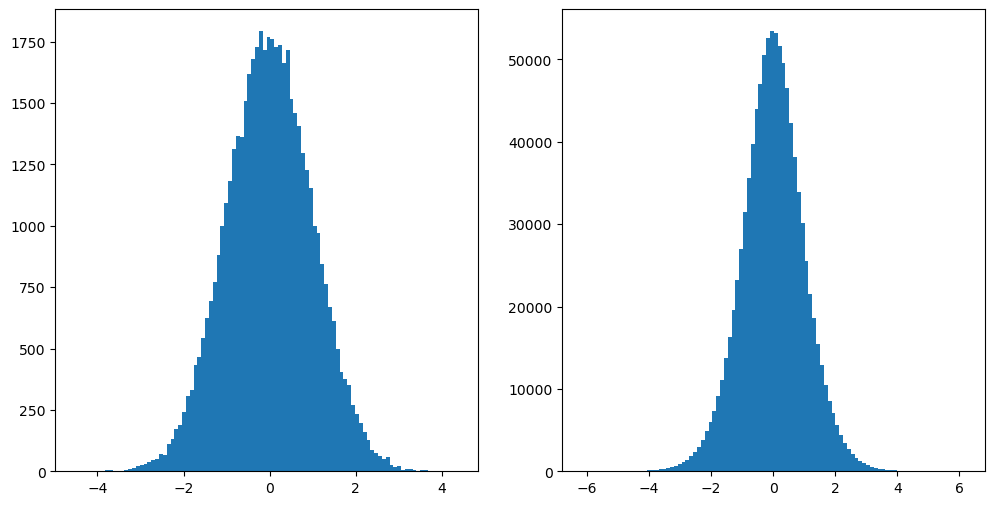

In [ ]:
x = torch.randn(5000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.hist(x.view(-1), bins=100)
plt.subplot(122)
plt.hist(y.view(-1), bins=100)

### Training the MLP

In [ ]:
lossi = []
lri = []
stepi = []
losses = []
n_steps = 100000
batch_size = 32
for i in range(n_steps):
    # Minibatch Creation
    ix = torch.randint(0, X_train.shape[0], (batch_size,))
    Xb, Yb = X_train[ix], Y_train[ix]
    
    # Forward
    emb = C[Xb] #Take the embeddings
    embcat = emb.view(emb.shape[0], -1) #concatenate the embeddings (flatten)
    h_preact = (embcat @ W1) + b1 # hidden pre-activation
    bn_mean_i = h_preact.mean(0, keepdims=True)
    bn_std_i = h_preact.std(0, keepdims=True)
    h_preact = (h_preact - bn_mean_i) / bn_std_i # batch normalization
    h_preact = (h_preact * bn_gain) + bn_bias # scale and shift
    
    with torch.no_grad():
        bn_mean_running = 0.999 * bn_mean_running + 0.001 * bn_mean_i
        bn_std_running = 0.999 * bn_std_running + 0.001 * bn_std_i
    
    h = torch.tanh(h_preact) # hidden activation
    logits = (h @ W2) + b2 #  output layer (numerical values)
    # Neg Log lokelihood
    loss = F.cross_entropy(logits, Yb)
    
    #Backward
    for p in params:
        p.grad = None
    loss.backward() 
    
    # update params
    lr = 0.1 if i < int(.5*n_steps) else 0.01
    # lr = lri[i]
    for p in params:
        p.data += -p.grad * lr
    # lossi.append(loss.item())
    # lri.append(lr)
    
    # track metrics
    if i%10000 == 0:
        print(f'{i:7d}/{n_steps:7d} Loss: {loss.item():.4f}')
    stepi.append(i)
    losses.append(loss.log10().item())
    #break

      0/ 100000 Loss: 3.3031
  10000/ 100000 Loss: 2.2790
  20000/ 100000 Loss: 2.3995
  30000/ 100000 Loss: 2.3055
  40000/ 100000 Loss: 2.3427
  50000/ 100000 Loss: 2.2162
  60000/ 100000 Loss: 2.4212
  70000/ 100000 Loss: 1.7287
  80000/ 100000 Loss: 2.2004
  90000/ 100000 Loss: 2.0421


## Mean and std at the end

In [ ]:
with torch.no_grad():
    emb = C[X_train]
    embcat = emb.view(emb.shape[0], -1)
    h_preact = (embcat @ W1) + b1
    # mean and std of the pre-activation
    bn_mean = h_preact.mean(0, keepdims=True)
    bn_std = h_preact.std(0, keepdims=True)

In [ ]:
bn_mean - bn_mean_running, bn_std - bn_std_running

(tensor([[-5.9548e-03,  5.7364e-04, -1.2883e-02,  1.3322e-02, -3.1403e-03,
          -9.9706e-03,  4.3741e-03,  4.5461e-03, -2.9509e-04, -1.8848e-03,
           4.7635e-03,  1.6488e-03,  4.9937e-03,  4.7287e-03, -1.0324e-03,
           1.6215e-04, -9.7117e-03, -8.5670e-03,  6.0941e-03,  9.6607e-03,
           8.9467e-03,  5.5776e-03,  8.7173e-03,  5.3463e-03, -9.7471e-03,
          -6.8569e-03, -5.6993e-03, -6.6200e-03, -1.0496e-02, -9.4970e-03,
          -7.6787e-03, -4.7698e-03, -9.1848e-03,  1.0433e-02,  8.0186e-03,
          -3.4928e-05, -1.0386e-03,  3.9042e-03,  1.2398e-03, -1.2679e-03,
           5.0466e-03, -2.5850e-03,  1.9603e-02,  1.0204e-02, -4.7762e-03,
          -1.0173e-02, -1.8486e-03,  1.1358e-03,  7.9529e-03,  4.5261e-03,
           9.0418e-03, -3.1364e-04, -3.1092e-03,  9.4927e-03, -6.0205e-03,
           1.7527e-03, -1.1096e-02,  8.9425e-03,  2.4262e-03, -1.8895e-03,
          -3.3842e-03,  7.5495e-03, -8.9301e-04, -1.0327e-02,  5.1459e-03,
          -1.8097e-05, -5

## Check Losses

In [ ]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (X_train, Y_train),
        'valid': (X_valid, Y_valid),
        'test': (X_test, Y_test)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h_preact = (embcat @ W1) + b1
    h_preact = (h_preact - bn_mean_running) / bn_std_running
    h_preact = (h_preact * bn_gain) + bn_bias
    h = torch.tanh(h_preact)
    logits = (h @ W2) + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('valid')
split_loss('test') 

train 2.080108165740967
valid 2.114428997039795
test 2.117600440979004


## Visualize Losses

Text(0, 0.5, 'Loss')

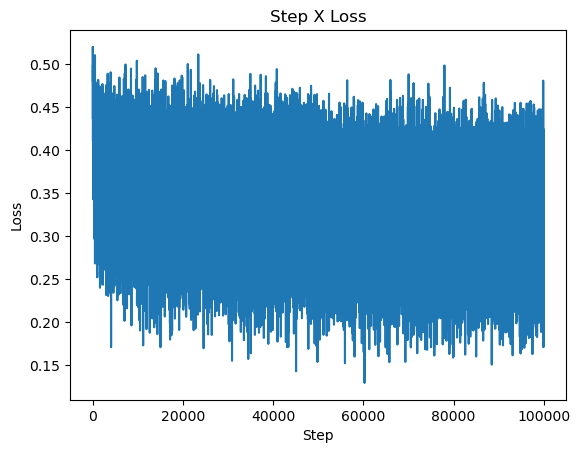

In [ ]:
plt.plot(stepi, losses)
plt.title("Step X Loss")
plt.xlabel("Step")
plt.ylabel("Loss")

In [ ]:
# plt.subplots(1, 2, figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.plot(lri, lossi)
# plt.title("Learning Rate X Loss")
# plt.xlabel("Learning Rate")
# plt.ylabel("Loss")
# plt.subplot(1, 2, 2)
# plt.plot(lre, lossi)
# plt.title("Exp Learning Rate X Loss")
# plt.xlabel("Exp Learning Rate")
# plt.ylabel("Loss")


## Visualize embeddings

In [ ]:
C[:, 1]

tensor([ 0.0147,  0.0625, -0.0673,  0.0812,  0.0327, -0.0849,  0.0482,  0.0849,
         0.0116,  0.0620,  0.0408,  0.0190,  0.0013, -0.0472,  0.0286,  0.0121,
         0.1128,  0.0411,  0.0101, -0.0239, -0.0531,  0.0226, -0.1596, -0.0011,
         0.0309, -0.0318,  0.0730], grad_fn=<SelectBackward0>)

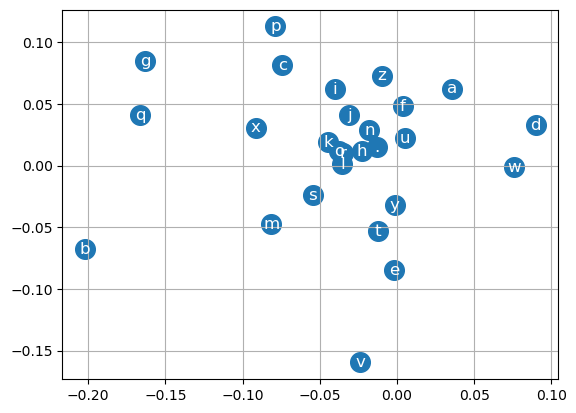

In [ ]:
# plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], fontsize=12, ha="center", va="center", color="white")
plt.grid('minor')

## Sampling from the model

In [ ]:
for _ in range(20):
    out = []
    context = [0]*block_size
    with torch.no_grad():
        while True:
            emb = C[torch.tensor([context])]
            h_preact = emb.view(1, -1) @ W1 + b1
            h_preact = (h_preact - bn_mean) / bn_std
            h_preact = h_preact * bn_gain + bn_bias
            h = torch.tanh(h_preact)
            logits = h @ W2 + b2
            probs = F.softmax(logits, dim=1)
            ix = torch.multinomial(probs, 1).item()
            context = context[1:] + [ix]
            out.append(ix)
            if ix == 0: break
        print(''.join([itos[i] for i in out]))

rah.
janariel.
daenesa.
charylyn.
nah.
jayce.
demonder.
cord.
ever.
heileanebertessin.
semi.
farah.
juna.
oveah.
suec.
shityani.
sos.
gaviholmwe.
nalexyn.
mayah.
